In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [3]:
import networkx as nx
import numpy as np
import random
import pandas as pd
import seaborn as sns
import epi_process as ep
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation
sns.set()

In [ ]:
class EpiProcess():
    def __init__(self, size, percent, viz=False):
        #вызываем стартовые инциализаторы
        self.paramertrs_init(size, percent, viz)

        self.graph_init()  

        self.random_start_sample()
        
        if self.viz:
            self.viz_init(viz)

    def paramertrs_init(self, size, percent, viz):
        #инициализируем параметры процесса
        self.size = size
        self.percent = percent
        self.cummulitive_sum_I = 0
        self.iterations = []
        self.viz=viz
    def graph_init(self):
        #строим configuration_model
        sequence = nx.random_powerlaw_tree_sequence(self.size, tries=5000000)
        self.G = nx.configuration_model(sequence)

    def viz_init(self,viz):
        #инциализируем необходимое для визуализации распростронения
        self.fig = None
        self.axes = None
        self.pos = nx.spring_layout(self.G)
        self.gif=[]
        self.colors = sns.color_palette("hls", 8)

    def random_start_sample(self):
        #Инициализация множеств индивидуумов, изначальной выборки
        self.start_sample_size = int(self.size/100 * self.percent)
        self.S = set(self.G)
        self.I = set()
        self.R = set()
        self.tmp = set()
        self.result = []

        #Заражаем изначальный процент
        while len(self.I)<self.start_sample_size:
            self.infect(random.randint(0, self.size))
        
    def infect(self, x):
        #Заражаем конкретного индивиидума путём перемещения его из множества
        self.S.discard(x)
        if not x in self.R:
            self.I.add(x)
        
    def recover(self, x):
        #Конкретный индивидуум переболел перемещаем его в множество переболевших
        self.I.discard(x)
        self.R.add(x)

    def infect_neigh(self, x):
        #метод заражения соседей
        for neigh in self.G.neighbors(x):
                self.infect(neigh)
        
    def iterartion(self):
        #метод итерации в графе
        #создаем копию больных что бы ничего не испортить
        self.tmp = self.I.copy()

        #для больных заражаем соседей а сам больной восстанавливается
        for x in self.tmp:
            self.infect_neigh(x)
            self.recover(x)
        
    def run(self):
        if self.viz == True:
            #если включена визуализация
            while len(self.I) != 0:
                #добавляем текущую итерацию в список картинок
                self.gif.append(self.vis_spread_info())

                #добавляем в результирующий список больных на текущий момент
                self.result.append(len(self.I))

                #проводим следующую итерацию
                self.iterartion()

            #повторяем для последней итерации    
            self.result.append(len(self.I))
            self.gif.append(self.vis_spread_info())
        else:
            #если визуализация выключена
            while len(self.I) != 0:
                 #добавляем в результирующий список больных на текущий момент
                self.result.append(len(self.I))

                #проводим следующую итерацию
                self.iterartion() 

            #повторяем для последней итерации      
            self.result.append(len(self.I))
    def viz_run(self):
        #метод визуализации распростронения по количеству больных на момент времени
        #получаем из списка результа данные в нужном формате
        y = pd.Series(self.result, name="count")

        #конвертируем итерации в моменты врмени
        x = pd.Series(range(1,len(self.result)+2), name="iteration")

        return sns.lineplot(x,y)

    def plot_degree_dist(self):
        #лямда перебора количества соседей для каждой вершины
        degrees = [self.G.degree(n) for n in self.G.nodes()]

        sns.displot(degrees)

    def plot_degree_dist_neigh(self):
        #получаем график распредления среднего количества соседей среди сосдеей для каждой вершины графа 
        sns.displot(nx.average_neighbor_degree(self.G))

    def vis_spread_info(self):
        #получаем актуальные цвета вершин на текущую итерацию
        colors = (list([self.colors[0]] * len(self.S)) + 
        list([self.colors[1]] * len(self.I)) + 
        list([self.colors[2]] * len(self.R)))

        #получаем актуальную принадлежность множествам вершин на текущую итерацию
        nodes = (list(self.S) +
                 list(self.I) + 
                 list(self.R))

        return nodes,colors

    def update(self,num):
        #рисуем актуальный граф на итерацию Num

        nx.draw_networkx_nodes(self.G, pos=self.pos, nodelist=self.gif[num][0], node_color=self.gif[num][1])
    def viz_joint(self):
        #получаем данные
        neigh=nx.average_neighbor_degree(self.G)
        degrees = [self.G.degree(n) for n in self.G.nodes()]
        #конвертируем в пандас
        y = pd.Series(neigh, name="avg_neigh_degree")

        x = pd.Series(degrees, name="degrees")

        #рисуем
        sns.jointplot(x,y)

Работа процессов

In [4]:
my_proc = ep.EpiProcess(1000,1,False)
my_proc.run()
print(my_proc.S)
print(my_proc.I)
print(my_proc.R)
print(len(my_proc.S)+len(my_proc.I)+len(my_proc.R))
print(my_proc.result)

{4, 5, 8, 10, 16, 18, 20, 24, 25, 26, 27, 28, 29, 32, 33, 35, 37, 41, 42, 45, 51, 55, 56, 59, 63, 68, 71, 74, 76, 79, 81, 82, 85, 86, 87, 88, 91, 93, 95, 99, 100, 102, 103, 107, 112, 115, 116, 118, 121, 123, 124, 126, 130, 132, 136, 137, 140, 144, 145, 146, 149, 151, 154, 156, 158, 164, 165, 168, 173, 183, 185, 189, 190, 197, 200, 202, 205, 206, 208, 211, 215, 218, 219, 226, 227, 243, 246, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 260, 261, 262, 265, 272, 273, 274, 275, 276, 281, 283, 288, 290, 292, 300, 312, 319, 324, 329, 334, 335, 337, 339, 346, 347, 349, 352, 355, 360, 361, 363, 364, 365, 374, 376, 380, 381, 382, 383, 385, 387, 390, 402, 405, 406, 409, 410, 412, 415, 416, 424, 426, 427, 434, 436, 439, 440, 442, 445, 447, 450, 451, 453, 455, 456, 457, 460, 462, 463, 466, 468, 469, 484, 488, 492, 493, 499, 500, 503, 505, 507, 509, 510, 511, 512, 514, 519, 520, 523, 525, 531, 532, 537, 538, 539, 541, 543, 548, 551, 554, 555, 560, 564, 565, 567, 569, 573, 574, 586, 589, 596, 59

Как распространяется эпидемия во времени


#3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


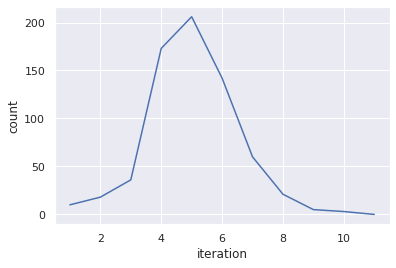

In [5]:
my_proc.viz_run()

#2 A)

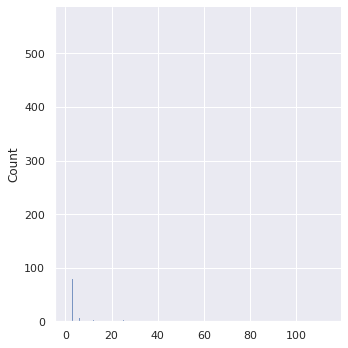

In [6]:
my_proc.plot_degree_dist()

# 2 B)

Распределение среднего количества соседей для вершин.


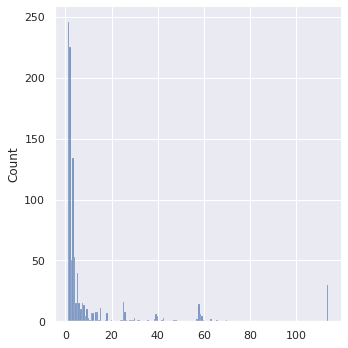

In [7]:
my_proc.plot_degree_dist_neigh()

Совместное распределение

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


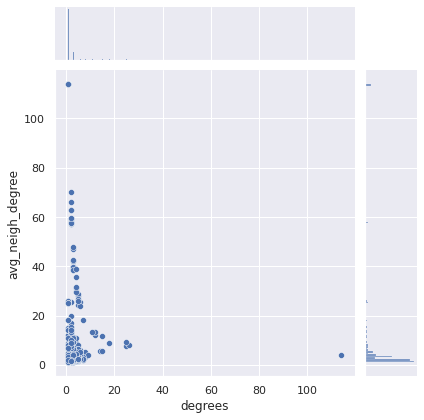

In [8]:
my_proc.viz_joint()

In [ ]:
fig = plt.gcf()

<Figure size 432x288 with 0 Axes>

# 1) Попытки в анимацию. Не работает :с

In [ ]:
ani = FuncAnimation(fig, my_proc.update,frames=range(len(my_proc.result)), interval=50)

In [ ]:
plt.show()

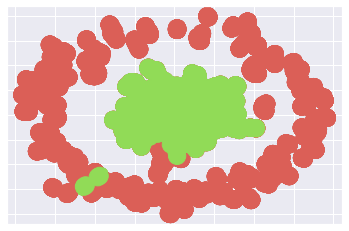

In [ ]:
ani.save('crap.gif', writer='pillow', fps=1)

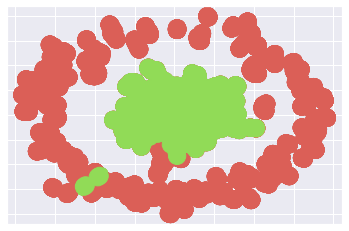

In [ ]:
writer = PillowWriter(fps=20)
ani.save("demo2.gif", writer=writer)

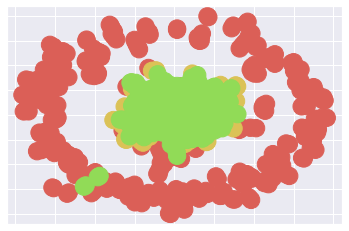

In [ ]:
my_proc.update(6)

#4) Много процессов их распределения


In [9]:
processes=[]
for x in range(0,9):
    processes.append(ep.EpiProcess(1000,1,False))
    processes[x].run()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

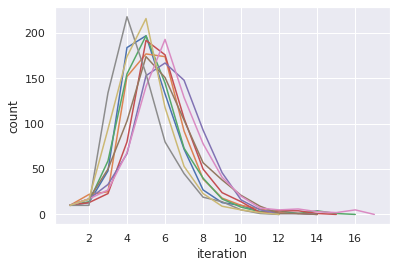

In [10]:
for x in processes:
    x.viz_run()